In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps

from sklearn.neural_network import MLPRegressor

In [3]:
with open("training.pkl", "rb") as f:
    df = pickle.load(f)

In [4]:
x = df[['x_pos', 'y_pos', 'x_vec', 'y_vec', 'x_dest', 'y_dest']].to_numpy()
y = df[['x_tar', 'y_tar']].to_numpy()

In [5]:
clf = MLPRegressor(verbose=True, hidden_layer_sizes=(50,100, 100, 50), max_iter=50).fit(x,y)

Iteration 1, loss = 0.20463849
Iteration 2, loss = 0.01080946
Iteration 3, loss = 0.00830739
Iteration 4, loss = 0.00755427
Iteration 5, loss = 0.00707107
Iteration 6, loss = 0.00685658
Iteration 7, loss = 0.00667114
Iteration 8, loss = 0.00655363
Iteration 9, loss = 0.00651609
Iteration 10, loss = 0.00647054
Iteration 11, loss = 0.00641382
Iteration 12, loss = 0.00639180
Iteration 13, loss = 0.00634500
Iteration 14, loss = 0.00633257
Iteration 15, loss = 0.00630252
Iteration 16, loss = 0.00627993
Iteration 17, loss = 0.00628059
Iteration 18, loss = 0.00626693
Iteration 19, loss = 0.00624978
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


In [62]:
input = [[602*2, 50*2, 0, 0, 50*2, 275*2]]
for i in range(10000):
    output = clf.predict(input)
    next = [output[0][0]+input[i][0], output[0][1]+input[i][1], output[0][0], output[0][1], input[i][-2], input[i][-1]]
    input.append(next)
x = np.array(input)

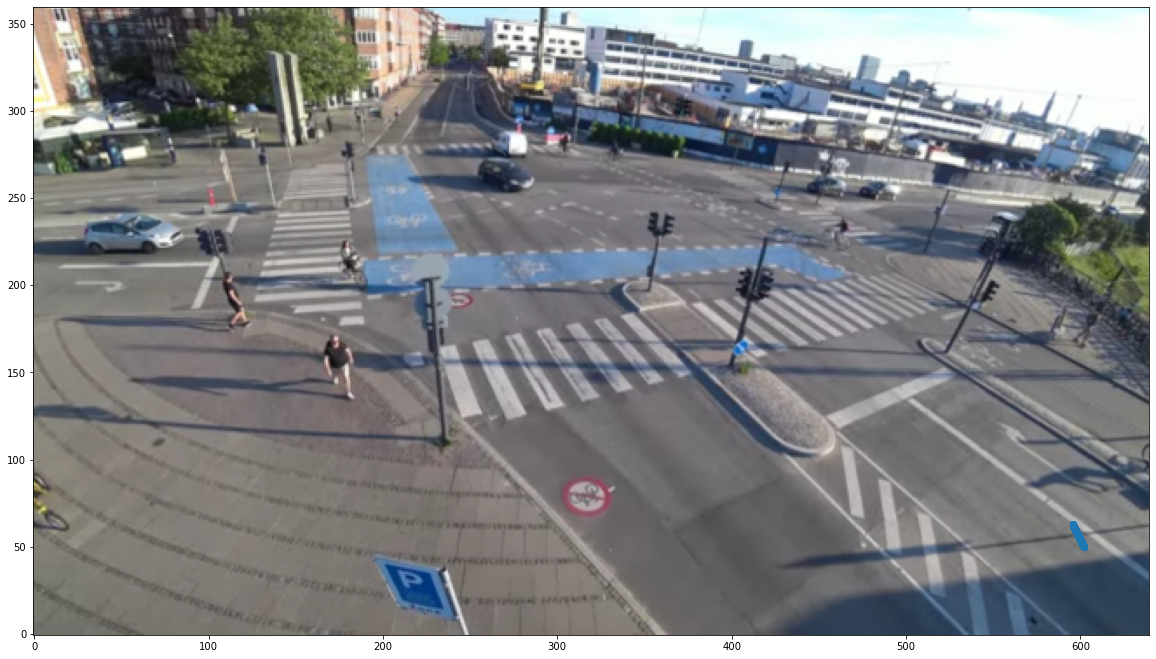

In [63]:
fig, ax = plt.subplots(figsize=(20,20))
im = Image.open("intersection2.png")
im = ImageOps.flip(im)
# ax.set_xlim(0,640)
# ax.set_ylim(0,360)
ax.imshow(im, origin='lower')
ax.scatter(x[:,:1]/2, x[:,1:2]/2)